# Chapter 3 - Linear Regression

In [65]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from scipy import stats
from sklearn.datasets import load_boston
from statsmodels.sandbox.regression.predstd import wls_prediction_std

%matplotlib inline
plt.style.use('ggplot') # emulate pretty r-style plots

In [27]:
# load data

boston = load_boston()
boston_data = np.column_stack([boston.data, boston.target])
col_names = np.append(boston.feature_names, 'MEDV')
boston_df = pd.DataFrame(boston_data, columns=col_names)

## Simple Linear Regression

### Using Scipy for linear regression

betas = 34.554, -0.95
R-value = -0.738, p-value = 0.000, standard error = 0.039


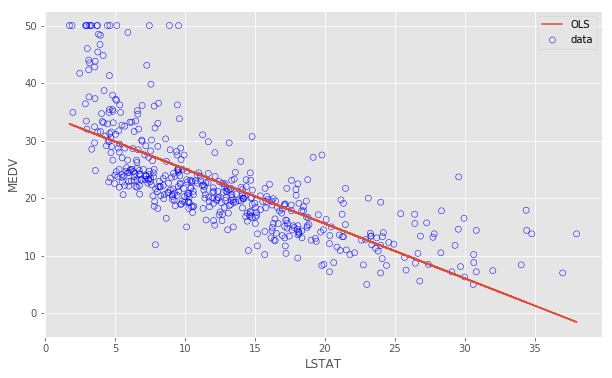

In [53]:
# using scipy for linear regression

fig, ax = plt.subplots(figsize=(10,6))
ax.scatter(boston_df.LSTAT.values, boston_df.MEDV.values, facecolors='none', \
           edgecolors='b', label='data')
ax.set_ylabel('MEDV')
ax.set_xlabel('LSTAT')

beta1, beta0, r_value, p_value, stderr = \
    stats.linregress(boston_df.LSTAT.values, boston_df.MEDV.values)
    
ax.plot(boston_df.LSTAT.values, beta0 + beta1 * boston_df.LSTAT.values, label='OLS')
ax.legend(loc='best')

print('betas = {}, {}'.format(round(beta0, 3), round(beta1, 3)))
print('R-value = {0:.3f}, p-value = {1:.3f}, standard error = {2:.3f}'.format(r_value, p_value, stderr))

### Using statsmodels for linear regression

In [64]:
# using statsmodels for linear regression
X = boston_df.LSTAT
X = sm.add_constant(X) # add constant for interceptor term
Y = boston_df.MEDV

linear_model = sm.OLS(Y, X)
linear_results = linear_model.fit()

print(linear_results.summary())

                            OLS Regression Results                            
Dep. Variable:                   MEDV   R-squared:                       0.544
Model:                            OLS   Adj. R-squared:                  0.543
Method:                 Least Squares   F-statistic:                     601.6
Date:                Sat, 05 May 2018   Prob (F-statistic):           5.08e-88
Time:                        15:15:16   Log-Likelihood:                -1641.5
No. Observations:                 506   AIC:                             3287.
Df Residuals:                     504   BIC:                             3295.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         34.5538      0.563     61.415      0.0

### Prediction and confidence intervals

In [75]:
prstd, iv_l, iv_u = wls_prediction_std(linear_results)

from statsmodels.stats.outliers_influence import summary_table

simpleTable, data, column_names = summary_table(linear_results, alpha=0.05)

print('column names ', column_names)

predicted_mean_ci_low, predicted_mean_ci_high = data[:,4:6].T

column names  ['Obs', 'Dep Var\nPopulation', 'Predicted\nValue', 'Std Error\nMean Predict', 'Mean ci\n95% low', 'Mean ci\n95% upp', 'Predict ci\n95% low', 'Predict ci\n95% upp', 'Residual', 'Std Error\nResidual', 'Student\nResidual', "Cook's\nD"]


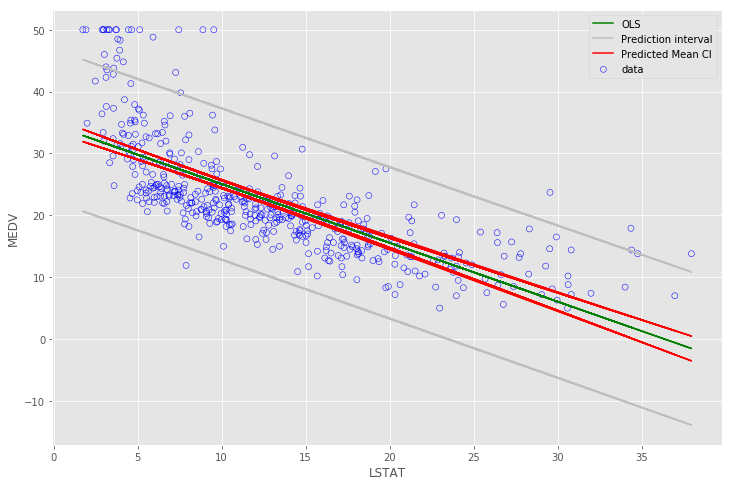

In [92]:
fig, ax = plt.subplots(figsize=(12,8))

X = boston_df.LSTAT.values
Y = boston_df.MEDV.values

ax.scatter(X, Y, facecolors='none', edgecolors='b', label='data')
ax.plot(X, linear_results.fittedvalues, 'g', label='OLS')

# plot prediction intervals
ax.plot(X, iv_u, color='0.75', label='Prediction interval')
ax.plot(X, iv_l, color='0.75')

# plot confidence intervals
ax.plot(X, predicted_mean_ci_low, 'r', label='Predicted Mean CI')
ax.plot(X, predicted_mean_ci_high, 'r')

ax.legend(loc='best')

plt.xlabel('LSTAT')
plt.ylabel('MEDV')

### Diagnostic plots for Simple Linear Regression

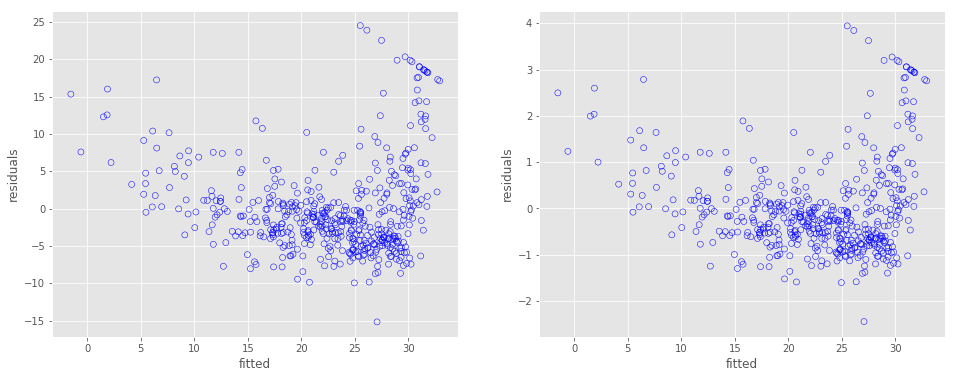

In [103]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16,6))

fitted_values = linear_results.fittedvalues.values
residuals = linear_results.resid.values

ax1.scatter(fitted_values, residuals, facecolors='none', edgecolors='b')
ax1.set_xlabel('fitted')
ax1.set_ylabel('residuals')

# plot studentized residuals, absolues values > 3 considered outliers
studentized_residuals = data[:, 10]
ax2.scatter(fitted_values, studentized_residuals, facecolors='none', edgecolors='b')
ax2.set_xlabel('fitted')
ax2.set_ylabel('residuals')

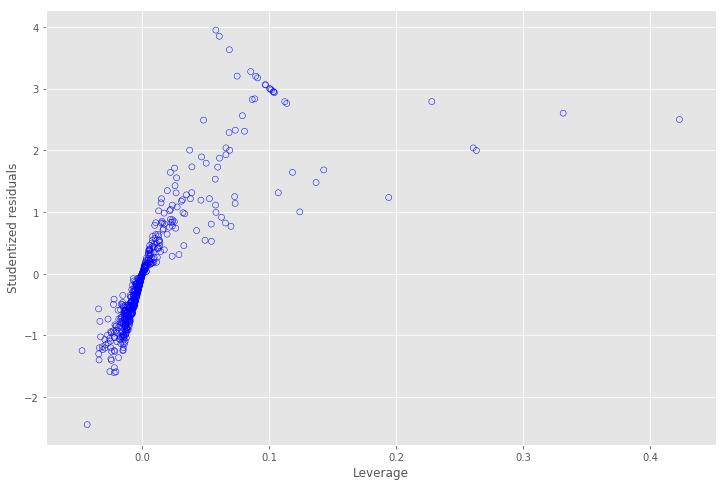

In [110]:
from statsmodels.stats.outliers_influence import OLSInfluence
leverage = OLSInfluence(linear_results).influence

fig, ax = plt.subplots(figsize=(12, 8))
ax.scatter(leverage, studentized_residuals, facecolors='none', edgecolors='b')
ax.set_xlabel('Leverage')
ax.set_ylabel('Studentized residuals')

## Multiple Linear Regression

First, we regress LSTAT and AGE onto MEDV.

In [130]:
X = sm.add_constant(boston_df[['LSTAT', 'AGE']])
Y = boston_df.MEDV

model = sm.OLS(Y, X)
results = model.fit()
print('Model paramsters: \n', results.params)

Model paramsters: 
 const    33.222761
LSTAT    -1.032069
AGE       0.034544
dtype: float64


Next, we regress all predictor onto the target variable.

In [134]:
X = sm.add_constant(boston_df.iloc[:, 0:-1])
model = sm.OLS(Y, X)
results = model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                   MEDV   R-squared:                       0.741
Model:                            OLS   Adj. R-squared:                  0.734
Method:                 Least Squares   F-statistic:                     108.1
Date:                Sat, 05 May 2018   Prob (F-statistic):          6.95e-135
Time:                        15:55:02   Log-Likelihood:                -1498.8
No. Observations:                 506   AIC:                             3026.
Df Residuals:                     492   BIC:                             3085.
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         36.4911      5.104      7.149      0.0

### Computer Variance Inflation factors 

In [138]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
vif = [(predictor, variance_inflation_factor(X.values, _)) for _, predictor in enumerate(list(X))]

print('Variance inflation factors')
for f in vif:
    print('{0:10} {1:.3f}'.format(f[0], f[1]))

Variance inflation factors
const      585.425
CRIM       1.773
ZN         2.299
INDUS      3.991
CHAS       1.074
NOX        4.395
RM         1.934
AGE        3.101
DIS        3.957
RAD        7.481
TAX        9.008
PTRATIO    1.799
B          1.346
LSTAT      2.938


## Interaction terms

In [142]:
# internally it uses patsy to represent models as formulas
import statsmodels.formula.api as smf

In [143]:
model = smf.ols(formula='MEDV ~ LSTAT*AGE', data=boston_df)
estimate = model.fit()
print(estimate.summary())

                            OLS Regression Results                            
Dep. Variable:                   MEDV   R-squared:                       0.556
Model:                            OLS   Adj. R-squared:                  0.553
Method:                 Least Squares   F-statistic:                     209.3
Date:                Sat, 05 May 2018   Prob (F-statistic):           4.86e-88
Time:                        16:02:44   Log-Likelihood:                -1635.0
No. Observations:                 506   AIC:                             3278.
Df Residuals:                     502   BIC:                             3295.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     36.0885      1.470     24.553      0.0

In [145]:
model = smf.ols(formula='MEDV ~ LSTAT + I(LSTAT**2)', data=boston_df)
quadratic_results = model.fit()
print(quadratic_results.summary())

                            OLS Regression Results                            
Dep. Variable:                   MEDV   R-squared:                       0.641
Model:                            OLS   Adj. R-squared:                  0.639
Method:                 Least Squares   F-statistic:                     448.5
Date:                Sat, 05 May 2018   Prob (F-statistic):          1.56e-112
Time:                        16:03:41   Log-Likelihood:                -1581.3
No. Observations:                 506   AIC:                             3169.
Df Residuals:                     503   BIC:                             3181.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept        42.8620      0.872     49.149

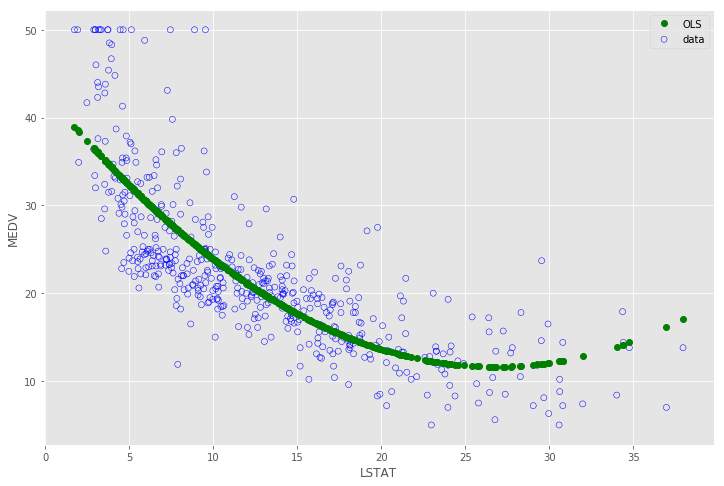

In [151]:
fig, ax = plt.subplots(figsize=(12,8))

X = boston_df.LSTAT.values
Y = boston_df.MEDV.values

ax.scatter(X, Y, facecolors='none', edgecolors='b', label='data')
ax.set_ylabel('MEDV')
ax.set_xlabel('LSTAT')

ax.plot(X, quadratic_results.fittedvalues, 'g', marker='o', linestyle='none', label='OLS')

ax.legend(loc='best')

In [155]:
from statsmodels.stats.api import anova_lm

anova_table = anova_lm(linear_results, quadratic_results)
print(anova_table)

   df_resid           ssr  df_diff     ss_diff           F        Pr(>F)
0     504.0  19472.381418      0.0         NaN         NaN           NaN
1     503.0  15347.243158      1.0  4125.13826  135.199822  7.630116e-28


/home/ttauruss/anaconda2/envs/mlopen/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/home/ttauruss/anaconda2/envs/mlopen/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/home/ttauruss/anaconda2/envs/mlopen/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1818: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)


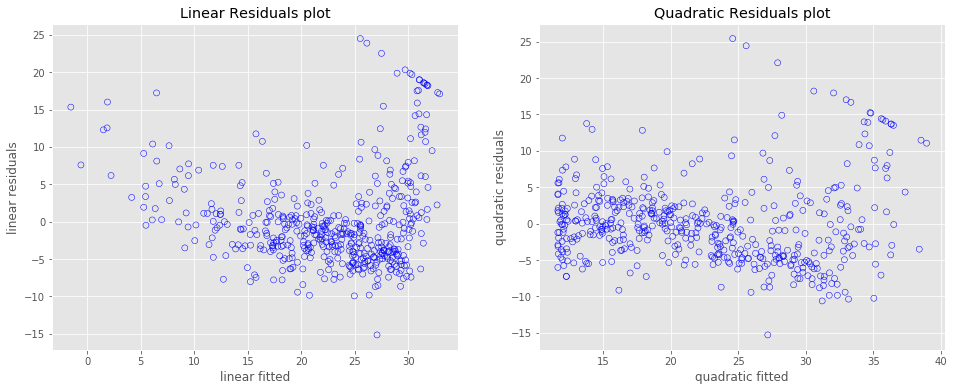

In [161]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16,6))

linear_fitted_values = linear_results.fittedvalues.values
linear_residuals = linear_results.resid.values

ax1.scatter(linear_fitted_values, linear_residuals, facecolors='none', edgecolors='b')
ax1.set_xlabel('linear fitted')
ax1.set_ylabel('linear residuals')
ax1.set_title('Linear Residuals plot')

quadratic_fitted_values = quadratic_results.fittedvalues.values
quadratic_residuals = quadratic_results.resid.values

ax2.scatter(quadratic_fitted_values, quadratic_residuals, facecolors='none', edgecolors='b')
ax2.set_xlabel('quadratic fitted')
ax2.set_ylabel('quadratic residuals')
ax2.set_title('Quadratic Residuals plot')

In [175]:
formula = 'MEDV ~ 1 + ' + ' + '.join('I(LSTAT**{})'.format(i) for i in range(1, 6))
model = smf.ols(formula, data=boston_df)
poly_5_order_results = model.fit()
print(poly_5_order_resultscarseats_df = pd.read_csv('../data/Carseats.csv',index_col = 0).summary())

                            OLS Regression Results                            
Dep. Variable:                   MEDV   R-squared:                       0.682
Model:                            OLS   Adj. R-squared:                  0.679
Method:                 Least Squares   F-statistic:                     214.2
Date:                Sat, 05 May 2018   Prob (F-statistic):          8.73e-122
Time:                        16:17:58   Log-Likelihood:                -1550.6
No. Observations:                 506   AIC:                             3113.
Df Residuals:                     500   BIC:                             3139.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept        67.6997      3.604     18.783

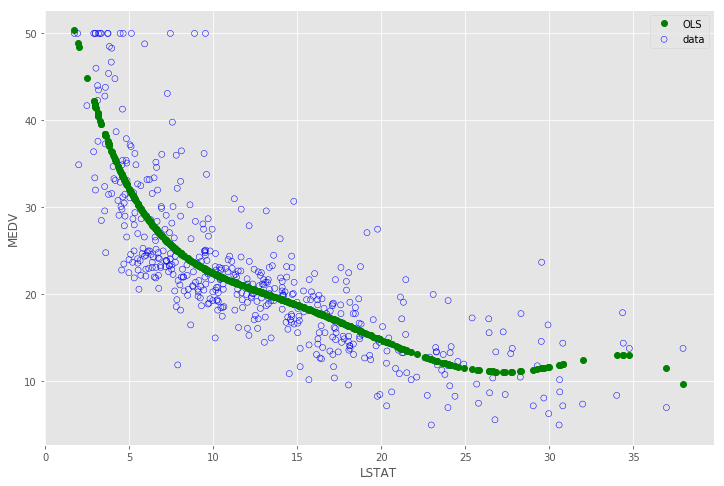

In [176]:
fig, ax = plt.subplots(figsize=(12,8))

X = boston_df.LSTAT.values
Y = boston_df.MEDV.values

ax.scatter(X, Y, facecolors='none', edgecolors='b', label='data')
ax.set_ylabel('MEDV')
ax.set_xlabel('LSTAT')

ax.plot(X, poly_5_order_results.fittedvalues, 'g', marker='o', linestyle='none', label='OLS')

ax.legend(loc='best')

## Qualitative Predictors

In [178]:
carseats_df = pd.read_csv('../data/Carseats.csv',index_col = 0)

We will predict Sales in carseats dataset. The predictor ShelveLoc is qualitative.

In [179]:
carseats_df.head()

,Sales,CompPrice,Income,Advertising,Population,Price,ShelveLoc,Age,Education,Urban,US
1,9.50,138,73,11,276,120,Bad,42,17,Yes,Yes
2,11.22,111,48,16,260,83,Good,65,10,Yes,Yes
3,10.06,113,35,10,269,80,Medium,59,12,Yes,Yes
4,7.40,117,100,4,466,97,Medium,55,14,Yes,Yes
5,4.15,141,64,3,340,128,Bad,38,13,Yes,No


In [185]:
simple_predictors = '+'.join(carseats_df.columns[1:].tolist())
formula = 'Sales ~ ' + simple_predictors + ' + Income:Advertising + Price:Age'

In [188]:
model = smf.ols(formula, data=carseats_df)
carseats_results = model.fit()
print(carseats_results.summary())

                            OLS Regression Results                            
Dep. Variable:                  Sales   R-squared:                       0.876
Model:                            OLS   Adj. R-squared:                  0.872
Method:                 Least Squares   F-statistic:                     210.0
Date:                Sat, 05 May 2018   Prob (F-statistic):          6.14e-166
Time:                        16:24:14   Log-Likelihood:                -564.67
No. Observations:                 400   AIC:                             1157.
Df Residuals:                     386   BIC:                             1213.
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept               6.5756    